# Prepraring the interactome inference

---

This notebook will be used to set the stage for the inference of the cell type specific interactome. To this end, we will be analyzing data from a scRNA-seq study, bulk sequencing data from the CCLE data set, curated gene sets e.g. from the Reactome data base and protein-protein interaction data curated in the iRefIndex data base. Additionally, we will use information regarding the specificity of the genes targeted in the overexpression study by Rohban et al. (2017). Such information are derived from preceeding analyses working on the imaging data. We will explain the used data sets further at a later stage.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3, venn3_unweighted
import venn
import networkx as nx
from sklearn.mixture import GaussianMixture
from scipy.stats import ttest_1samp, pearsonr, spearmanr
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import mutual_info_score
import matplotlib.cm as cm

import sys

sys.path.append("../../..")

from src.utils.notebooks.ppi.preprocessing import *

seed = 1234

%load_ext nb_black

<IPython.core.display.Javascript object>

---

## 1. Read in data

We will read in a number of different data sets that we will use for our analyses: a) the single-cell gene expression data from Mahdessian et al. (2021), b) the most recent version of the CCLE expression data set, c) the list of ORF gene targets from the study by Rohban et al. (2017) and finally d) the Human PPI network as defined by the iRefIndexDB v14, e) a number of curated gene sets and f) the results of our image-based preceeding specificity screen.

The gene sets we read in are those describing the Reactome pathways related to the DNA damage repair, cell cycle, chromating organization as well as the list of human transcription factors and the set corresponding to the KEGG regulation of actin cytoskeleton pathway.

In [2]:
fucci_adata = sc.read("../../../data/gex/scrnaseq/fucci_adata.h5")
fucci_adata.var_names_make_unique()
fucci_data = pd.DataFrame(
    fucci_adata.X, columns=fucci_adata.var_names, index=fucci_adata.obs_names
)
fucci_data.columns = [c.upper() for c in fucci_data.columns]
fucci_data.head()

,TSPAN6,DPM1,SCYL3,C1ORF112,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,...,NOTCH2NLR,SPDYE14,DERPC,BMS1P23,LOC107986257,LOC728392,NOTCH2NLC,SPDYE11,ARMCX5-GPRASP2,LOC114841035
A10_355,4.084212,4.450537,2.539949,3.306074,0.0,3.924660,2.747193,3.980721,3.192863,3.306074,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,3.111745,0.000000,0.0,0.0
A10_356,4.416176,3.408068,0.000000,3.341437,0.0,3.109879,3.637463,2.683064,2.919073,4.264037,...,0.000000,0.0,2.540241,2.038441,1.584074,0.0,0.328890,1.336015,0.0,0.0
A10_357,2.784883,4.266762,0.000000,3.756405,0.0,4.676425,4.027002,4.154050,3.560914,4.211993,...,3.527433,0.0,3.144496,0.000000,0.000000,0.0,3.733050,0.000000,0.0,0.0
A11_355,3.995154,4.196535,1.325398,3.543870,0.0,3.015254,3.015254,4.159373,0.000000,3.481722,...,0.000000,0.0,3.219861,1.930217,0.000000,0.0,2.597980,1.435097,0.0,0.0
A11_356,5.384314,3.358004,2.851447,2.519226,0.0,4.309559,3.807653,3.807653,3.843228,3.843228,...,0.000000,0.0,3.926349,0.000000,0.000000,0.0,0.000000,1.948682,0.0,0.0


<IPython.core.display.Javascript object>

In [3]:
fucci_gene_set = set(fucci_data.columns)

<IPython.core.display.Javascript object>

The single-cell gene expression data from Mahdessian et al. (2021) to which we in the following refer to as FUCCI data set consists of 1'126 cells a 21'445.

In [4]:
ccle_data = pd.read_csv("../../../data/gex/ccle/CCLE_expression.csv", index_col=0)
ccle_sample_info = pd.read_csv(
    "../../../data/gex/ccle/CCLE_expression_sample_info.csv", index_col=0
)
matched_ids = set(ccle_sample_info.index).intersection(ccle_data.index)
ccle_data = ccle_data.loc[list(matched_ids)]
ccle_data.index = ccle_sample_info.loc[ccle_data.index, "stripped_cell_line_name"]
ccle_data.columns = [c.split(" ")[0].upper() for c in ccle_data.columns]
ccle_data.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1ORF112,FGR,CFH,FUCA2,GCLC,NFYA,...,ARHGAP11B,AC004593.2,AC090517.4,AL160269.1,ABCF2-H2BE1,POLR2J3,H2BE1,AL445238.1,GET1-SH3BGR,AC113348.1
stripped_cell_line_name,,,,,,,,,,,,,,,,,,,,,
OVSAHO,5.533563,0.0,7.121948,2.295723,4.121015,0.014355,2.726831,5.361768,3.224966,4.782933,...,1.350497,0.097611,0.056584,0.000000,3.928844,5.090853,0.0,0.000000,1.632268,0.000000
TALL1,0.310340,0.0,6.512385,3.161888,5.387500,4.002703,1.757023,1.077243,4.999098,5.708463,...,3.548437,0.111031,0.042644,0.000000,2.788686,5.747119,0.0,0.000000,0.214125,0.000000
HEKTE,5.012122,0.0,6.454998,2.032101,4.057450,0.028569,2.821710,6.315059,3.500802,4.400538,...,2.144046,0.028569,0.070389,0.000000,2.198494,4.925999,0.0,0.000000,0.238787,0.000000
SNU1105,4.310340,0.0,5.811985,2.042644,3.938286,0.176323,4.132577,7.151676,4.224966,4.302319,...,2.475085,0.097611,0.028569,0.084064,3.848998,6.681449,0.0,0.056584,0.464668,0.000000
HHUA,5.929318,0.0,6.579995,1.632268,2.411426,0.000000,0.000000,6.658497,3.609991,4.225738,...,0.226509,0.111031,0.084064,0.000000,1.090853,4.774524,0.0,0.000000,0.516015,0.084064


<IPython.core.display.Javascript object>

In [5]:
ccle_gene_set = set(ccle_data.columns)

<IPython.core.display.Javascript object>

The second data set from the CCLE study consist of 1'378 cancer cell lines for which we obtain the expression of roughly 19'177 genes.

Next, we load the previously mentioned gene sets.

In [6]:
cell_cycle_genes = set(
    pd.read_csv(
        "../../../data/other/reactome_cell_cycle.txt", index_col=0, header=None
    ).index
)

<IPython.core.display.Javascript object>

In [7]:
chrom_org_genes = set(
    pd.read_csv(
        "../../../data/other/reactome_chrom_org.txt", index_col=0, header=None
    ).index
)

<IPython.core.display.Javascript object>

In [8]:
dna_repair_genes = set(
    pd.read_csv(
        "../../../data/other/reactome_dna_repair.txt", index_col=0, header=None
    ).index
)

<IPython.core.display.Javascript object>

In [9]:
reg_actin_cytoskeleton_genes = set(
    pd.read_csv(
        "../../../data/other/kegg_reg_act_cytoskeleton.txt", index_col=0, header=None
    ).index
)

<IPython.core.display.Javascript object>

In [10]:
human_tfs = set(
    list(
        pd.read_csv(
            "../../../data/other/human_tf_list.txt", index_col=0, header=None
        ).index
    )
)

<IPython.core.display.Javascript object>

In [11]:
specificity_screen_results = pd.read_csv(
    "../../..//data/other/specificity_screen_results.csv", index_col=0
)
specificity_screen_results.head()

,multi_image_spec_score,nuclei_image_spec_score,spec_score,rohban_selected,pathways_of_interest,selected
MAPK13,0.586119,0.547602,0.586119,False,False,False
AKT2,0.604911,0.547991,0.604911,False,True,False
MAP3K7,0.468750,0.530357,0.530357,True,False,False
IKBKB,0.685855,0.607730,0.685855,False,False,True
IRAK1,0.620404,0.538603,0.620404,False,False,False


<IPython.core.display.Javascript object>

In [12]:
specific_targets = set(
    specificity_screen_results.loc[specificity_screen_results["selected"] == True].index
)
orf_targets = set(specificity_screen_results.index)

<IPython.core.display.Javascript object>

Finally we load the human PPI as curated in the iRefIndexDB v14.

In [13]:
ppi_file = "../../../data/ppi/iRefIndex_v14_MIScore_interactome_C9.costs.txt"
iref_ppi = nx.convert_matrix.from_pandas_edgelist(
    pd.read_csv(ppi_file, sep="\t"),
    source="protein1",
    target="protein2",
    edge_attr="cost",
)
iref_ppi.remove_edges_from(nx.selfloop_edges(iref_ppi))
iref_ppi.name = "human PPI"

<IPython.core.display.Javascript object>

In [14]:
ppi_gene_set = set(list(iref_ppi.nodes()))

<IPython.core.display.Javascript object>

In [69]:
for edge in iref_ppi.edges(data=True):
    edge[-1]["mi_score"] = edge[-1]["cost"]

<IPython.core.display.Javascript object>

In [70]:
print(nx.info(iref_ppi))

Name: filtered PPI
Type: Graph
Number of nodes: 15759
Number of edges: 181955
Average degree:  23.0922


<IPython.core.display.Javascript object>

The network consists of 15'759 nodes and 181'955 edges with an average node degree of 23.0922.

---

## 2. Preliminary analyses

Next, we will analyze the data to i.a. define the gene set that we want to focus on in the remainder of the study.

The Venn diagram below shows the overlap of the two gene sets with the 190 ORF targets from the study by Rohban et al. (2017) as well as with the ones from iRefIndexDB v14. That we will use later on as a basis to derive the interactome specific to the U2OS cells.

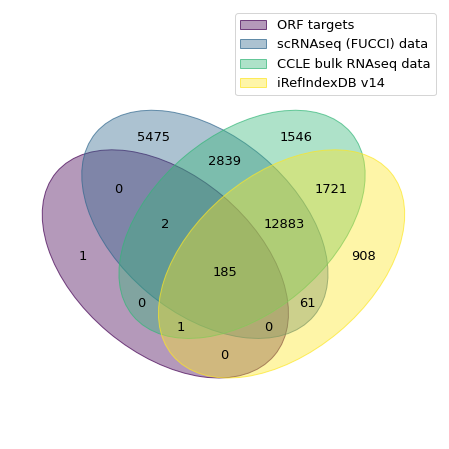

<IPython.core.display.Javascript object>

In [72]:
ax = venn.venn(
    dict(
        zip(
            [
                "ORF targets",
                "scRNAseq (FUCCI) data",
                "CCLE bulk RNAseq data",
                "iRefIndexDB v14",
            ],
            [
                orf_targets,
                fucci_gene_set,
                ccle_gene_set,
                ppi_gene_set,
            ],
        )
    )
)

In [73]:
selected_orf_targets = orf_targets.intersection(fucci_gene_set).intersection(
    ppi_gene_set
)
# pd.DataFrame(list(selected_orf_targets)).to_csv(
#     "../../../data/other/selected_orf_targets.txt", header=False, index=False
# )

<IPython.core.display.Javascript object>

Going forward, we will focus on the intersection of the genes that are covered in the scRNAseq (FUCCI) data set, the CCLE bulk RNAseq data set and the iRefIndexDB v14. While we will have not yet decided to use the bulk-sequencing data restricting us to those genes also covered by this gene expression data set only removes 61 genes including four known transcription factors (NFE4, ZNF286B, ZNF658B, ZNF702P) transcription factor nor any of the ORF targets, which are shown below.

In [74]:
selected_gene_set = fucci_gene_set.intersection(ppi_gene_set).intersection(
    ccle_gene_set
)

<IPython.core.display.Javascript object>

The selected gene set consists of 13'068 genes all of which are covered in either of the two RNAseq data sets and the human PPI.

---

## 2. Identification of U2OS gene set

In total we have 13'068 genes that we selected for further analyses. However, we have to yet identify those that are particularly important in the functional and thus regulatory programs of our cell type: human osteosarcoma (U2OS) cells.

### 2a. CCLE data marker screen

To identify the markers, we use the CCLE bulk RNAseq data set.
This data set provides the average expression for roughly 20'000 genes for 1'378 different cancer cell lines including U2OS cells.

Inspired by we identify those genes that are differentially expressed (regulated) in U2OS cells when comparing those to the background distribution from the remaining 1'377 cancer cell lines in the data set. To identify those we test for every gene if the mean expression of all other cancer cell lines is significantly different than the expression of that respective gene for U2OS cells using the bulk RNAseq data. In particular, we will test the following for each gene:

$$
H_A: \quad \bar{x}_i = x_{i,U2OS}, \quad \textrm{with} \ \bar{x}_i=\frac{1}{N-1}\sum\limits_{j\neq U2OS}x_{i,j}
$$
where $x_{i,j}$ is the transformed expression of gene $i$ in cell type $j$. Note that due to the large sample size we will assume the log-transformed gene expression for each gene to approximately follow a standard normal distribution. Thus, we will perform a one sample t-test to assess the significance of any under-or overexpression.

Note that we subset the gene set to those that are also present in both the scRNAseq data set and the human PPI.

In [75]:
ccle_data = ccle_data.loc[:, selected_gene_set]

<IPython.core.display.Javascript object>

In [76]:
marker_results = find_markers(
    ccle_data,
    target="U2OS",
    avg_log_fc=0.0,
    min_pct=0,
)

<IPython.core.display.Javascript object>

The table below shows the top 10 genes that show the largest absolute log-fold change when comparing U2OS cells vs. the other cancer cell lines of the CCLE data set.

In [77]:
marker_results.loc[(marker_results["fdr"] < 0.05)].sort_values(
    "abs_log_fc", ascending=False
).head(10)

,log_expr_target,avg_log_expr_other,log_fc,abs_log_fc,pval,fdr
DHRS2,10.913937,2.265074,8.648862,8.648862,0.0,0.0
PAGE2,7.891055,0.447193,7.443861,7.443861,0.0,0.0
HAPLN1,7.514122,0.537060,6.977062,6.977062,0.0,0.0
KRT81,9.080338,2.109525,6.970813,6.970813,0.0,0.0
PCLO,8.285310,1.510797,6.774512,6.774512,0.0,0.0
KRT17,9.705892,2.965366,6.740525,6.740525,0.0,0.0
CXCL14,6.953382,0.699980,6.253402,6.253402,0.0,0.0
TNNC1,7.932451,1.779374,6.153077,6.153077,0.0,0.0
MAGEA1,7.011898,0.922583,6.089315,6.089315,0.0,0.0
KRT75,6.136068,0.190374,5.945694,5.945694,0.0,0.0


<IPython.core.display.Javascript object>

The absolute log-fold change for those roughly 13k genes exponentially decays with the maximum being 8.649. The figure below shows the absolute log-fold change for each gene in decreasing order.

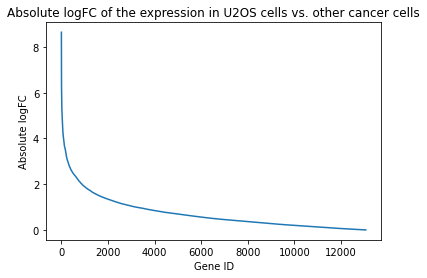

<IPython.core.display.Javascript object>

In [78]:
plt.figure()
plt.plot(
    list(range(len(marker_results))),
    np.array(
        marker_results.sort_values("abs_log_fc", ascending=False).loc[:, "abs_log_fc"]
    ),
)
plt.ylabel("Absolute logFC")
plt.xlabel("Gene ID")
plt.title("Absolute logFC of the expression in U2OS cells vs. other cancer cells")
plt.show()


---

### 2b. The ORF targets as U2OS marker

Next, we look a little bit more in depth at the genes that were targeted in the image-based over-expression screen by Rohban et al (2017). Those genes are of particular interest for our study. Even more important are those genes that showed a specific structural phenotype different from the control setting upon over-expression. This has been evaluated in our preceeding specificity screen. Please refer to the corresponding notebook for further explanation on this step.

The plots below show the previously computed absolute log-fold change for the 185 ORF targets that are covered by the human PPI and both RNAseq data sets.

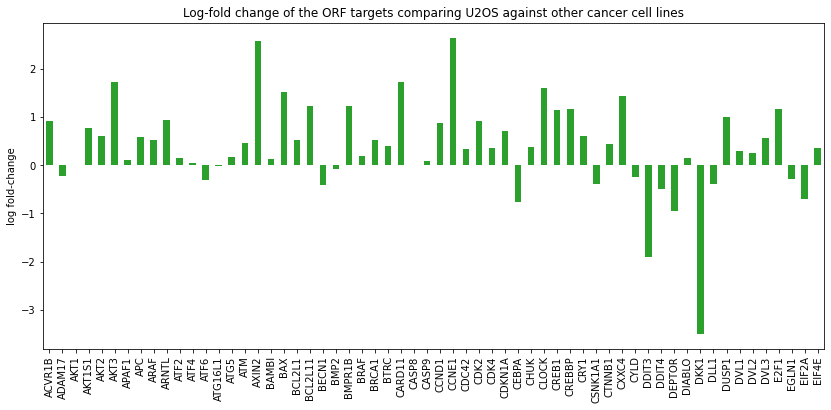

<IPython.core.display.Javascript object>

In [79]:
orf_log_fc = marker_results.loc[
    set(list(marker_results.index)).intersection(orf_targets), "log_fc"
]
orf_log_fc.sort_index().iloc[:60].plot.bar(figsize=[14, 6], color="tab:green")
plt.ylabel("log fold-change")
plt.title(
    "Log-fold change of the ORF targets comparing U2OS against other cancer cell lines"
)
plt.show()

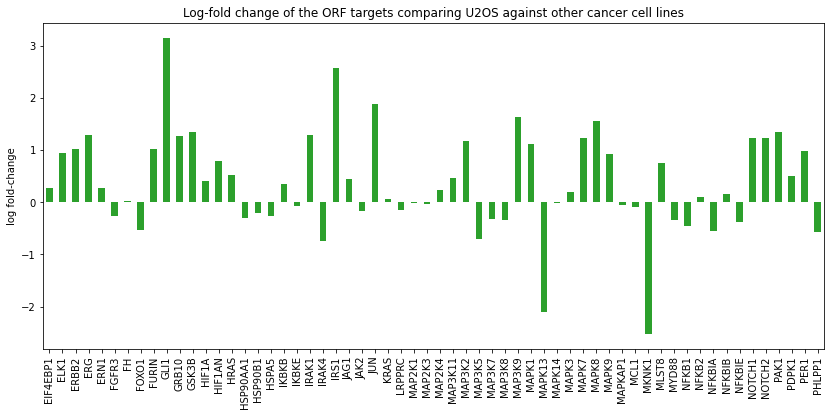

<IPython.core.display.Javascript object>

In [80]:
orf_log_fc.sort_index().iloc[60:120].plot.bar(figsize=[14, 6], color="tab:green")
plt.ylabel("log fold-change")
plt.title(
    "Log-fold change of the ORF targets comparing U2OS against other cancer cell lines"
)
plt.show()

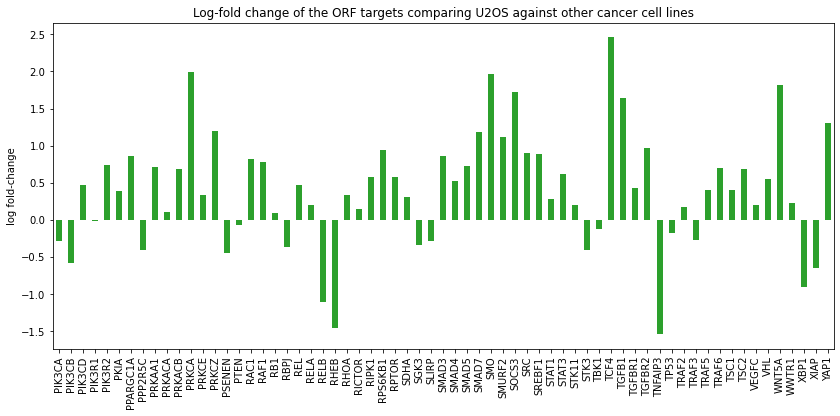

<IPython.core.display.Javascript object>

In [81]:
orf_log_fc.sort_index().iloc[120:].plot.bar(figsize=[14, 6], color="tab:green")
plt.ylabel("log fold-change")
plt.title(
    "Log-fold change of the ORF targets comparing U2OS against other cancer cell lines"
)
plt.show()

We see a quite heterogenous distribution of the absolute log-fold change for the individual ORF targets as also visualized in the histogram below.

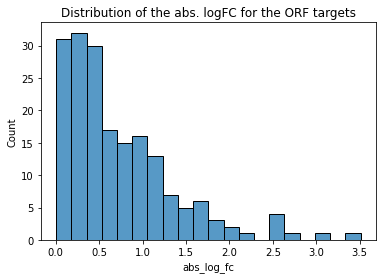

<IPython.core.display.Javascript object>

In [82]:
orf_abs_log_fc = marker_results.loc[
    set(list(marker_results.index)).intersection(orf_targets), "abs_log_fc"
]
fig = plt.figure()
sns.histplot(data=orf_abs_log_fc, bins=20)
plt.title("Distribution of the abs. logFC for the ORF targets")
plt.show()

Importantly, we see that many ORF targets are not strongly differentially regulated in U2OS cells when compared to other cancer cell lines. This also holds true for those target genes that yielded a specific structural phenotype upon overexpression in the image-based study.

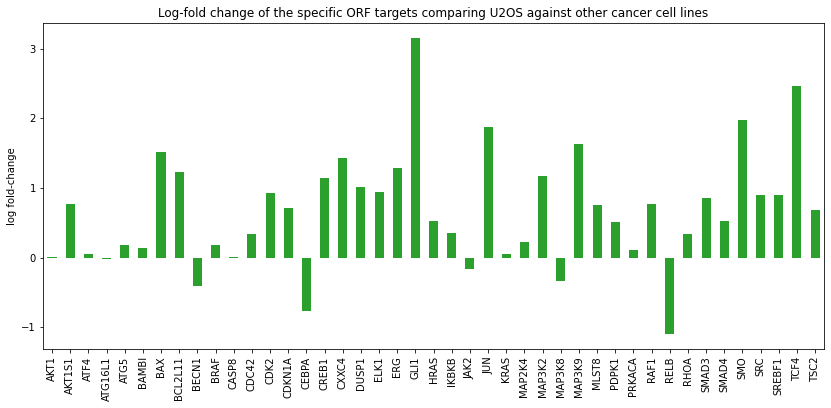

<IPython.core.display.Javascript object>

In [83]:
specific_targets_abs_log_fc = marker_results.loc[
    set(list(marker_results.index)).intersection(specific_targets), "log_fc"
]
specific_targets_abs_log_fc.sort_index().plot.bar(figsize=[14, 6], color="tab:green")
plt.ylabel("log fold-change")
plt.title(
    "Log-fold change of the specific ORF targets comparing U2OS against other cancer cell lines"
)
plt.show()

Importantly, with the exception of CEBPA all of those genes are fairly high expressed in wild-type U2OS cells.

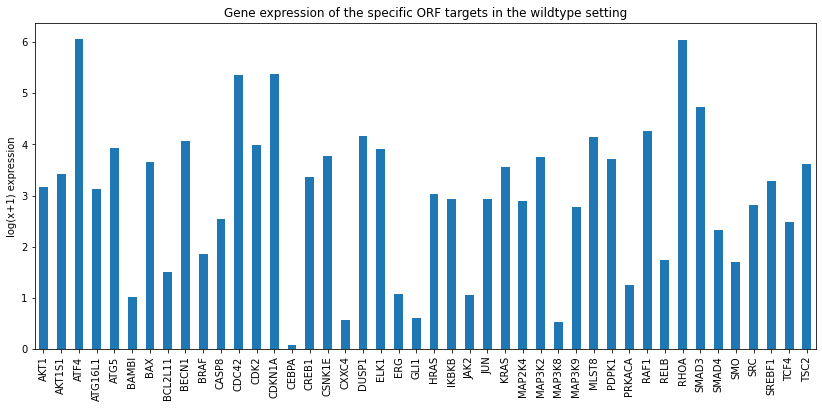

<IPython.core.display.Javascript object>

In [84]:
fucci_data.loc[:, sorted(specific_targets)].mean().plot.bar(figsize=[14, 6])
plt.ylabel("log(x+1) expression")
plt.title("Gene expression of the specific ORF targets in the wildtype setting")
plt.show()

We will keep that in mind for later.

---

## 3. Preprocessing the PPI

After assessing the importance of each of the genes in our selected gene set as markers of U2OS cells when comparing them to other cancer cell lines, we will now turn to the human PPI. The human PPI as curated in the iRefIndex data base is constructed based on many different data sources and thus provides a rather general description of the interactive relationships of proteins respective the genes that code for those in human cell lines.

To derive a subnetwork that is specific to U2OS cells and well capture the specific regulatory relationships of our selected gene sets in those cells, we will perform a number of preprocessing steps. 


### 3.1. Remove uncovered genes

As an initial step we will focus on the subnetwork that we obtain by filtering out all genes that are not covered in both of the RNAseq data sets.

In [85]:
filtered_ppi = iref_ppi.subgraph(selected_gene_set)
filtered_ppi.name = "filtered PPI"
print(nx.info(filtered_ppi))

Name: filtered PPI
Type: Graph
Number of nodes: 13068
Number of edges: 153980
Average degree:  23.5660


<IPython.core.display.Javascript object>

In [86]:
filtered_ppi

<IPython.core.display.Javascript object>

The corresponding network consists of 13'068 nodes describing individual genes and 153'980 describing the interactive relationships between these genes.

Note that this splits the human PPI into 110 disconnected components. However importantly the largest connected component spans all ORF targets.

In [87]:
ccomps = [
    filtered_ppi.subgraph(c).copy() for c in nx.connected_components(filtered_ppi)
]
filtered_ppi = ccomps[0]

print(nx.info(filtered_ppi))

Name: filtered PPI
Type: Graph
Number of nodes: 12956
Number of edges: 153977
Average degree:  23.7692


<IPython.core.display.Javascript object>

This network consists of 12'956 nodes and 153'977 edges with an average degree of 23.76 .

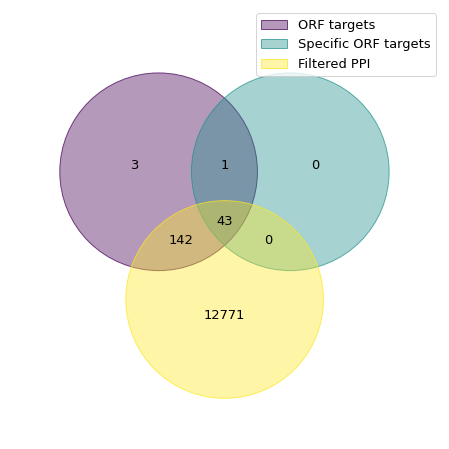

<IPython.core.display.Javascript object>

In [88]:
ax = venn.venn(
    dict(
        zip(
            [
                "ORF targets",
                "Specific ORF targets",
                "Filtered PPI",
            ],
            [
                orf_targets,
                specific_targets,
                set(filtered_ppi.nodes()),
            ],
        )
    )
)

This network importantly no longer includes 4/189 ORF targets among which is one target that we found to to yield a specific structural phenotype upon overexpression namely CSNK1E. The remaining targets that are not covered are IRGM, MEK1 and MOS.

In [89]:
orf_targets - set(filtered_ppi.nodes())

{'CSNK1E', 'IRGM', 'MEK1', 'MOS'}

<IPython.core.display.Javascript object>

---

### 3.2 Remove hub nodes

Next, we will further analyze the network and aim to reduce its connectivity by excluding large hub-nodes that are of less interest for our further analyses and might disguise important indirect links between certain targets.
Thus, let us look at the distribution of the degrees of the nodes in the network.

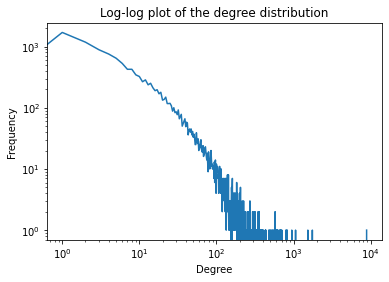

<IPython.core.display.Javascript object>

In [90]:
degree_freq = nx.degree_histogram(filtered_ppi)
degrees = range(len(degree_freq))
plt.loglog(degrees, degree_freq)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Log-log plot of the degree distribution")
plt.show()

We see that there are a few nodes with extreme high degrees. In order to avoid a bias for those nodes in the downstream task of inferring the U2OS specific interactome, we will remove some of such hub nodes from the interactome. This is further motivated by the fact that we would like to emphasize the differences between individual pathways in which our observed ORF targets are included.

In [91]:
degrees_dict = dict(filtered_ppi.degree())
degrees_dict = {
    k: v
    for k, v in sorted(degrees_dict.items(), key=lambda item: item[1], reverse=True)
}
nodes = np.array(list(degrees_dict.keys()))
degrees = np.array(list(degrees_dict.values()))

<IPython.core.display.Javascript object>

To determine an appropriate cutoff of for degree of the nodes to identify those hubnodes that we do not want to take into further consideration, we look at the number of ORF targets that are included in the selected gene set, when using different percentile-cutoffs for the node degree.

In [92]:
cutoffs = np.arange(0.5, 1.0, 0.001)
hub_node_cutoff_screen = run_hub_node_cutoff_analyses(
    filtered_ppi,
    cutoffs=cutoffs,
    targets=orf_targets,
    keep_targets=False,
    specific_targets=specific_targets,
)

Screen cutoffs: 100%|██████████| 500/500 [02:19<00:00,  3.59it/s]


<IPython.core.display.Javascript object>

To this end, we will plot the number of connected components, the size of the largest connected component, the number of edges of the largest connected component, the average degree in the largest connected component, the number of all/specific ORF targets in the largest connected component.

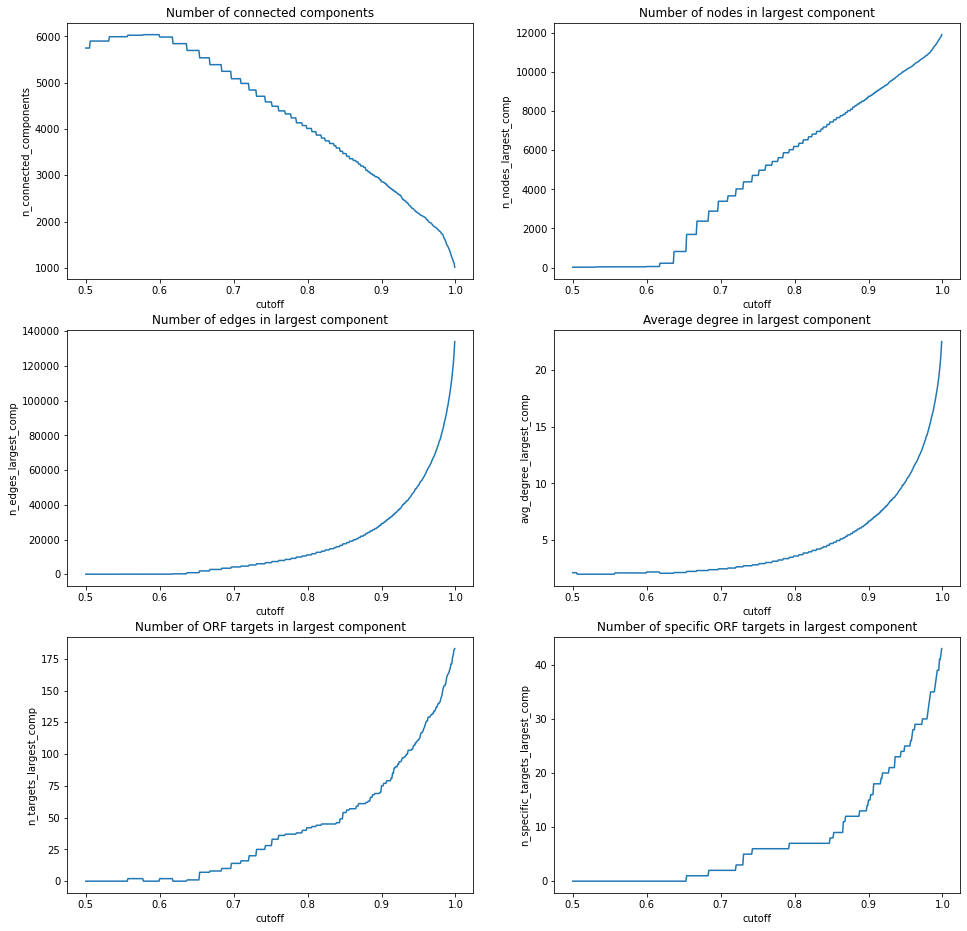

<IPython.core.display.Javascript object>

In [93]:
fig, ax = plt.subplots(figsize=[16, 16], nrows=3, ncols=2)
ax = ax.flatten()

ax[0] = sns.lineplot(
    data=hub_node_cutoff_screen, x="cutoff", y="n_connected_components", ax=ax[0]
)
ax[0].set_title("Number of connected components")

ax[1] = sns.lineplot(
    data=hub_node_cutoff_screen, x="cutoff", y="n_nodes_largest_comp", ax=ax[1]
)
ax[1].set_title("Number of nodes in largest component")

ax[2] = sns.lineplot(
    data=hub_node_cutoff_screen, x="cutoff", y="n_edges_largest_comp", ax=ax[2]
)
ax[2].set_title("Number of edges in largest component")

ax[3] = sns.lineplot(
    data=hub_node_cutoff_screen, x="cutoff", y="avg_degree_largest_comp", ax=ax[3]
)
ax[3].set_title("Average degree in largest component")

ax[4] = sns.lineplot(
    data=hub_node_cutoff_screen, x="cutoff", y="n_targets_largest_comp", ax=ax[4]
)
ax[4].set_title("Number of ORF targets in largest component")

ax[5] = sns.lineplot(
    data=hub_node_cutoff_screen, x="cutoff", y="specific_targets", ax=ax[5]
)
ax[5].set_ylabel("n_specific_targets_largest_comp")
ax[5].set_title("Number of specific ORF targets in largest component")

plt.show()

In [94]:
hub_node_cutoff_screen.sort_values("cutoff", ascending=False).head(10)

,cutoff,n_connected_components,n_nodes_largest_comp,n_targets_largest_comp,n_edges_largest_comp,avg_degree_largest_comp,specific_targets
499,0.999,1013,11920,183,133984,22.480537,43
498,0.998,1108,11812,182,126494,21.417880,42
497,0.997,1142,11765,178,120885,20.549936,41
496,0.996,1195,11699,176,116383,19.896230,41
495,0.995,1228,11652,171,112438,19.299348,39
494,0.994,1282,11585,171,108952,18.809150,39
493,0.993,1329,11525,168,105824,18.364252,39
492,0.992,1383,11458,166,102876,17.957061,38
491,0.991,1413,11416,164,100402,17.589699,37
490,0.990,1456,11356,163,97714,17.209229,36


<IPython.core.display.Javascript object>

In [95]:
hub_node_cutoff_screen.loc[
    hub_node_cutoff_screen["specific_targets"] == 43
].sort_values("cutoff").head(1)

,cutoff,n_connected_components,n_nodes_largest_comp,n_targets_largest_comp,n_edges_largest_comp,avg_degree_largest_comp,specific_targets
499,0.999,1013,11920,183,133984,22.480537,43


<IPython.core.display.Javascript object>

We see that by removing the top 0.1% of the nodes, the largest component still spans all 43 specific ORF targets.

We will thus conservatively choose to only remove the top 0.1% nodes. The resulting graph will span 183/185 ORF targets in the largest component and 42/44 specific ORF targets.

In [96]:
hub_cutoff = 0.999
degree_cutoff = np.quantile(list(dict(filtered_ppi.degree()).values()), hub_cutoff)
hubnodes = nodes[degrees >= degree_cutoff]
non_hubnodes = nodes[degrees < degree_cutoff]

<IPython.core.display.Javascript object>

In [97]:
for n in hubnodes:
    print("Node:", n, "(", degrees_dict[n], ")")

Node: UBC ( 8875 )
Node: APP ( 1755 )
Node: SUMO2 ( 1534 )
Node: CUL3 ( 1063 )
Node: SUMO1 ( 949 )
Node: TP53 ( 829 )
Node: EGFR ( 814 )
Node: SUMO3 ( 794 )
Node: MDM2 ( 705 )
Node: HSP90AA1 ( 694 )
Node: FN1 ( 677 )
Node: NEDD8 ( 674 )
Node: COPS5 ( 671 )


<IPython.core.display.Javascript object>

The hubnodes that will be filtered out are listed above.

We will now derive the subgraph that only spans the nodes not classified as hubnodes by our previous analyses.

Importantly, the subgraph induced by removing the identified hubnodes from the network does not remain fully connected and importantly one of the ORF targets that was shown to yield a specific structural phenotype upon overexpression becomes disconnected from the largest connected component that spans all other ORF targets.

In [98]:
selected_ppi = nx.Graph(filtered_ppi.subgraph(non_hubnodes))
selected_ppi.name = "hub_pruned_ppi"

<IPython.core.display.Javascript object>

Note that this graph importantly covers all of those targets in the largest connected component.

In [99]:
ccomps = [
    selected_ppi.subgraph(c).copy() for c in nx.connected_components(selected_ppi)
]
for comp in ccomps:
    if len(orf_targets.intersection(comp.nodes())) > 0:
        print(nx.info(comp))
        print(len(orf_targets.intersection(comp.nodes())))
        print(orf_targets.intersection(comp.nodes()))

Name: hub_pruned_ppi
Type: Graph
Number of nodes: 11920
Number of edges: 133984
Average degree:  22.4805
183
{'MAP3K7', 'JAG1', 'DVL2', 'PHLPP1', 'NFKB2', 'DDIT4', 'IRS1', 'CLOCK', 'STK3', 'IKBKE', 'SRC', 'E2F1', 'APC', 'MYD88', 'ADAM17', 'ERN1', 'IRAK4', 'MAP3K9', 'YAP1', 'PRKACA', 'BCL2L11', 'KRAS', 'STAT1', 'SGK3', 'BRAF', 'AKT3', 'ATM', 'HIF1A', 'NOTCH1', 'DKK1', 'GLI1', 'IRAK1', 'SDHA', 'CRY1', 'CTNNB1', 'NOTCH2', 'SMO', 'CYLD', 'SMURF2', 'PDPK1', 'ERBB2', 'CEBPA', 'TSC1', 'EGLN1', 'FGFR3', 'JAK2', 'GSK3B', 'TNFAIP3', 'TRAF5', 'BAX', 'RAC1', 'PIK3R1', 'RB1', 'MAP2K1', 'SMAD7', 'CDC42', 'PTEN', 'PIK3CD', 'FH', 'IKBKB', 'PSENEN', 'STAT3', 'CARD11', 'DIABLO', 'BRCA1', 'AKT2', 'PER1', 'PIK3R2', 'PRKACB', 'MAPK13', 'DEPTOR', 'CXXC4', 'DLL1', 'RAF1', 'PRKCZ', 'TBK1', 'MAPK7', 'MAP3K5', 'ELK1', 'BECN1', 'ACVR1B', 'CDK2', 'PPARGC1A', 'CHUK', 'RELA', 'DUSP1', 'JUN', 'XBP1', 'FOXO1', 'MCL1', 'NFKBIB', 'SOCS3', 'ATG16L1', 'RHEB', 'HIF1AN', 'RELB', 'CCNE1', 'PPP2R5C', 'NFKBIA', 'RIPK1', 'REL'

<IPython.core.display.Javascript object>

In [100]:
selected_ppi = ccomps[0]

<IPython.core.display.Javascript object>

The induced subgraph spans 11'920 nodes including 180/185 ORF targets with an average degree of 22.48 stemming from 133'984 edges.

---

## 4. Relationship strength of the between the selected genes

In this section we will look at ways to define the edge costs for the Prize-collecting Steiner tree inference-based derivation of the U2OS-specific interactome. To this end, we will look at three different measures that are often used to describe the association of genes to guide the derivation of regulatory networks and interactomes, namely the Pearson correlation, the Spearman correlation and the normalized mutual information. Since, we want to assign higher costs to for relationships between any pair of genes that we have little evidence for as measured by the three previously mentioned metrics, we compute these as

$$
w_{i,j} = 1-|a_{i,j}|,
$$

where $w_{i,j}$ is the edge weight and $a_{i,j}$ is the respective association of the genes $i$ and $j$ as measured by the metrics.

We will now compute the respective edge weights for any edge in the base PPI and visualize their distribution.

In [101]:
selected_ppi = compute_edge_weights(
    selected_ppi, fucci_data, b=100, metrics=["pearsonr", "spearmanr", "mi"]
)

Compute edge weights for mi: 100%|██████████| 133984/133984 [01:20<00:00, 1656.02it/s]


<IPython.core.display.Javascript object>

### 4.1. Pearson correlation-based edge weights

In [102]:
pearsonr_weights = np.array(
    list(nx.get_edge_attributes(selected_ppi, "pearsonr").values())
)

<IPython.core.display.Javascript object>

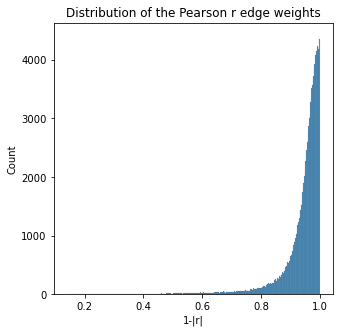

<IPython.core.display.Javascript object>

In [103]:
plt.figure(figsize=[5, 5])
sns.histplot(pearsonr_weights)
plt.title("Distribution of the Pearson r edge weights")
plt.xlabel("1-|r|")
plt.show()

### 4.2. Spearman correlation-based edge weights

In [104]:
spearmanr_weights = np.array(
    list(nx.get_edge_attributes(selected_ppi, "spearmanr").values())
)

<IPython.core.display.Javascript object>

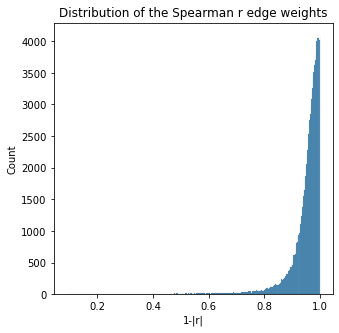

<IPython.core.display.Javascript object>

In [105]:
plt.figure(figsize=[5, 5])
sns.histplot(spearmanr_weights)
plt.title("Distribution of the Spearman r edge weights")
plt.xlabel("1-|r|")
plt.show()

### 4.3. Mutual information-based edge weights

In [106]:
mi_weights = np.array(list(nx.get_edge_attributes(selected_ppi, "mi").values()))

<IPython.core.display.Javascript object>

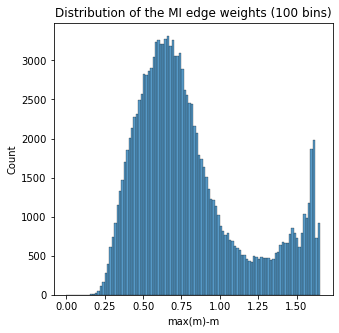

<IPython.core.display.Javascript object>

In [107]:
plt.figure(figsize=[5, 5])
sns.histplot(np.max(mi_weights) - (mi_weights))
plt.title("Distribution of the MI edge weights (100 bins)")
plt.xlabel("max(m)-m")
plt.show()

----

## 5. PCST preprocessing

After having computed the respective metrics we will now construct different version of the PPI with associated edge weights and node prizes for the inference of the PCST algorithm.

We decide to choose the absolute log fold-change as the the prizes associated with each node, but in order to ensure that the PCST algorithm will select the specific ORF targets we assign a prize to all of those targets that is equal to the maximum absolute log-fold change among the nodes in the network.

We decide to set the edge weights as $1-|r_{spearman}|$ computed from the scRNA-seq data set as in contrast to the Pearson correlation it can also capture non-linear relationships and has been shown to perform on par with more sophisticated measures in network inference tasks in several other work.

In [118]:
ppi_name = "hub_ppi_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr"

<IPython.core.display.Javascript object>

In [119]:
prepared_ppi = selected_ppi.copy()
prepared_ppi.name = ppi_name
abs_log_fc = marker_results.loc[:, "abs_log_fc"]

## Set node prizes
for node in prepared_ppi.nodes(data=True):
    if node[0] in specific_targets:
        node[-1]["prize"] = np.max(abs_log_fc)
    else:
        try:
            node[-1]["prize"] = abs_log_fc[node[0]]
        except KeyError:
            node[-1]["prize"] = 0


## Set edge weights
for edge in prepared_ppi.edges(data=True):
    edge[-1]["cost"] = edge[-1]["spearmanr"]

## Save network
nx.write_gpickle(prepared_ppi, "../../../data/ppi/{}.pkl".format(ppi_name))

<IPython.core.display.Javascript object>

---

## 6. Analyses of the PCST preprocessed graphs

To get a better understanding of the input graphs that we constructed for the PCST driven inference we will plot some basic characteristics of the input graph. For that we will first focus on the 3rd version that we constructed for which the edge weights are given by $1-|r_{Spearman}|$ and the prizes by the absolute log fold-change with the ones of the ORF targets constantly set to the maximum log fold-change.

In [110]:
graph = prepared_ppi
prizes = dict(nx.get_node_attributes(graph, "prize"))
costs = dict(nx.get_edge_attributes(graph, "cost"))

<IPython.core.display.Javascript object>

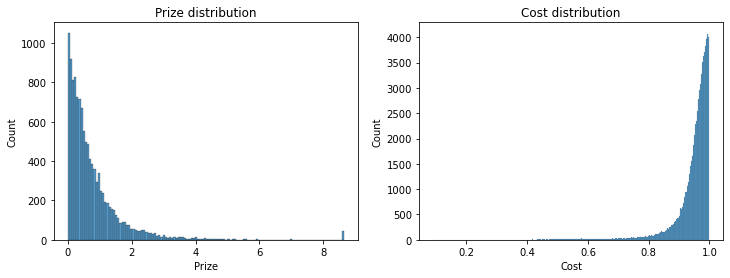

<IPython.core.display.Javascript object>

In [111]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12, 4])
ax = ax.flatten()
ax[0] = sns.histplot(prizes.values(), ax=ax[0], legend=False)
ax[0].set_title("Prize distribution")
ax[0].set_xlabel("Prize")
ax[1] = sns.histplot(costs.values(), ax=ax[1], legend=False)
ax[1].set_title("Cost distribution")
ax[1].set_xlabel("Cost")
plt.show()
plt.show()

We are now interested if there is a relationship between the prizes and edge costs and the corresponding nodes i.e. those that the edges associated with the costs connect to. To this end, we will plot the prizes by the corresponding edge degree and as well as the edge costs.

In [112]:
degrees = dict(graph.degree())
degrees = {k: v for k, v in sorted(degrees.items())}
prizes = {k: v for k, v in sorted(prizes.items())}
orf_target_colors = []
for k in prizes:
    orf_target_colors.append(k in orf_targets)

<IPython.core.display.Javascript object>

In [113]:
mean_node_cost = []
std_node_cost = []
node_degrees = []
node_orf_target_colors = []
for node in graph.nodes():
    node_orf_target_colors.append(node in orf_targets)
    node_degrees.append(graph.degree(node))
    edges = graph.edges(node, data=True)
    node_cost = []
    for edge in edges:
        node_cost.append(edge[-1]["cost"])
    mean_node_cost.append(np.mean(node_cost))
    std_node_cost.append(np.std(node_cost))

<IPython.core.display.Javascript object>

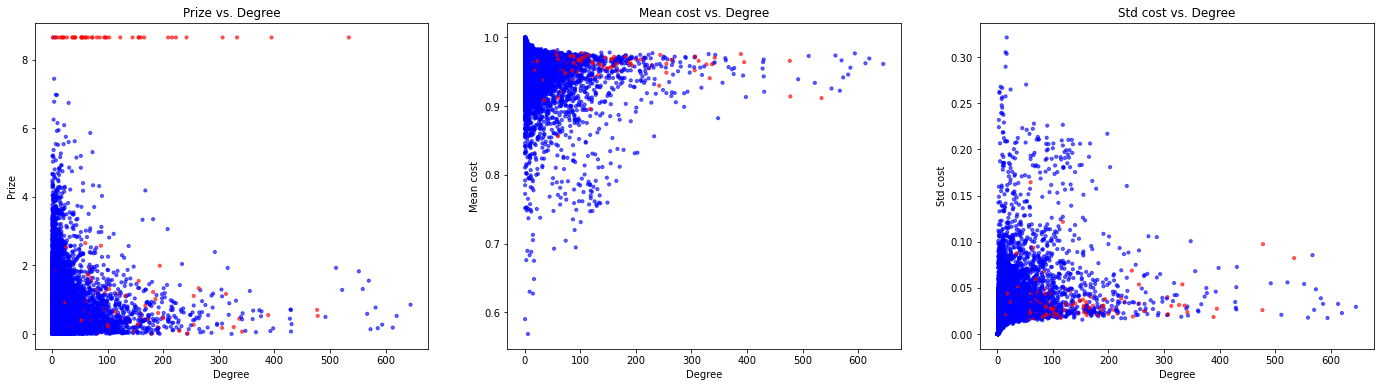

<IPython.core.display.Javascript object>

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[24, 6])
ax = ax.flatten()
ax[0].scatter(
    degrees.values(),
    prizes.values(),
    c=orf_target_colors,
    s=10,
    cmap="bwr",
    alpha=0.6,
)
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Prize")
ax[0].set_title("Prize vs. Degree")

ax[1].scatter(
    node_degrees, mean_node_cost, c=node_orf_target_colors, s=10, cmap="bwr", alpha=0.6
)
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("Mean cost")
ax[1].set_title("Mean cost vs. Degree")

ax[2].scatter(
    node_degrees, std_node_cost, c=node_orf_target_colors, s=10, cmap="bwr", alpha=0.6
)
ax[2].set_xlabel("Degree")
ax[2].set_ylabel("Std cost")
ax[2].set_title("Std cost vs. Degree")
plt.show()

The above plots illustrate that the most of nodes with a very high degree get relatively low yet non-zero prizes. Note, that due to the manual inflation of the prizes for the ORF targets that does not apply to those (marked in red). Additionally, most nodes with high-degrees are connected to many high cost edges as shown by the mean cost. Recalling the histogram of the overall edge cost distribution this is not surprising. The variance of the edge cost also decreases with increasing degree on average.

Jointly, this suggest that we might want to exclude even more high-degree nodes. However, this will also likely cause the largest connected component of the induced subgraph to span less of the ORF targets. Thus, it would be important to either manually include these as long as they can be connected to the largest connected component or that the ORF targets that are filtered out are of no special interest for the downstream analyses.

In [116]:
targets = ["CASP8", "CASP9", "BCL2L11", "DDIT3", "GRB10"]
dist = np.zeros([5, 5])
collect = np.zeros([5, 5])
for i in range(5):
    for j in range(5):
        dist[i, j] = nx.shortest_path_length(
            graph, source=targets[i], target=targets[j], weight="mi_score"
        )
        sp = nx.shortest_path(
            graph, source=targets[i], target=targets[j], weight="mi_score"
        )
        collect[i, j] = np.sum([prizes[n] for n in sp]) - dist[i, j]
dist = pd.DataFrame(dist, index=targets, columns=targets)
collect = pd.DataFrame(collect, index=targets, columns=targets)

<IPython.core.display.Javascript object>

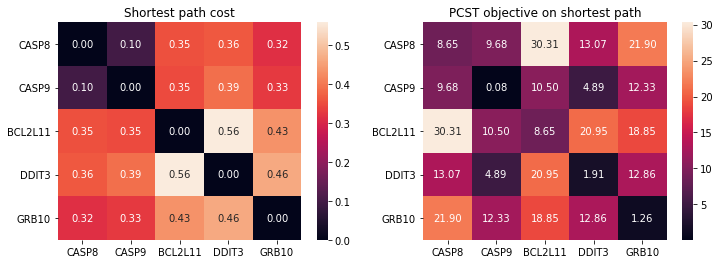

<IPython.core.display.Javascript object>

In [117]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12, 4])
ax = ax.flatten()
ax[0] = sns.heatmap(dist, annot=True, ax=ax[0], fmt=".2f")
ax[0].set_title("Shortest path cost")
ax[1] = sns.heatmap(collect, annot=True, ax=ax[1], fmt=".2f")
ax[1].set_title("PCST objective on shortest path")
plt.show()